# Задание 1. A/B–тестирование

Одной из основных задач аналитика является корректное проведение экспериментов. Для этого применяется метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Входные данные
В качестве входных данных есть 4 csv-файла:
groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
groups_add.csv - дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

В ходе анализа необходимо ответить на следующие вопросы:
- На какие метрики необходимо обращать внимание в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?


Перейдем к этапу загрузки файлов и предобработки данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import requests
import seaborn as sns
import os
from tqdm import tqdm
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import levene
from urllib.parse import urlencode

os.environ['OUTDATED_IGNORE'] = '1'

%matplotlib inline

In [2]:
# Ссылки на файлы
groups_url = r'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = r'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = r'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = r'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
# Загружаем CSV-файл по указанному URL с разделителем ','
def read_csv_yandex(url, delimiter=","):

    api_url = r"https://cloud-api.yandex.net/v1/disk/public/resources/download?"

    if "yandex" not in url or "ya" not in url:
        raise ValueError("URL должен быть с домена Яндекс.Диска")
        
    response = requests.get(api_url, params={"public_key": url})
    return pd.read_csv(response.json()["href"], delimiter=delimiter)

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [4]:
groups = read_csv_yandex(groups_url, ';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
# смотрим на структуру данных
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
# приведем столбец к числовому значению
groups['id'] = pd.to_numeric(groups['id'])

In [7]:
# проверяем количество строк
groups.shape

(74484, 2)

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [8]:
groups_add = read_csv_yandex(groups_add_url)
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
# смотрим на структуру данных
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [10]:
# приведем столбец к числовому значению
groups_add['id'] = pd.to_numeric(groups_add['id'])

In [11]:
# проверяем количество строк
groups_add.shape

(92, 2)

In [12]:
# проверяем количество уникальных значений
groups_add.nunique()

id     92
grp     2
dtype: int64

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [13]:
active_studs = read_csv_yandex(active_studs_url)
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [14]:
# смотрим на структуру данных
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [15]:
# проверяем количество строк
active_studs.shape

(8341, 1)

In [16]:
active_studs.nunique() # проверяем количество уникальных значений, задвоений нет и все student_id уникальны

student_id    8341
dtype: int64

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента

In [17]:
checks = read_csv_yandex(checks_url,';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [18]:
# смотрим на структуру данных
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [19]:
# приведем столбец к числовому значению
checks['rev'] = pd.to_numeric(checks['rev'])

In [20]:
# проверяем количество строк
checks.shape

(541, 2)

In [21]:
# проверяем количество уникальных значений, все student_id уникальны
checks.nunique()

student_id    541
rev            39
dtype: int64

Создадим датафрейм groups_merged, объединив groups и groups_add

In [22]:
groups_merged = pd.concat([groups, groups_add], ignore_index=True)

In [23]:
groups_merged

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [24]:
# Проверяем добавление (должно быть 74484 из groups и 92 из groups_add = 74576)
groups_merged.shape

(74576, 2)

In [25]:
# проверим дубликаты
duplicates_groups_merged = groups_merged.duplicated().sum()
print(duplicates_groups_merged)

0


Объединим active_studs и checks

In [26]:
active_checks = active_studs.merge(checks, on='student_id', how = 'left')
# переименуем столбцы в датафрейме
active_checks = active_checks.rename(columns = {'student_id': 'id', 'rev': 'revenue'})

In [27]:
active_checks.head()

,id,revenue
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN


Видим, что не все пользователи вносили оплату, посмотрим количество таких пользователей

In [28]:
# Посчитаем количество значений NaN в DataFrame active_checks
nan_count = active_checks.isna().sum()
print(nan_count)

id            0
revenue    7949
dtype: int64


In [29]:
active_checks.query('revenue.notna()')

,id,revenue
62,1184303,1530.0000
67,3354191,1900.0001
77,3278734,1900.0000
99,720651,1980.0000
193,1232221,1900.0000
...,...,...
8201,3890326,199.0000
8204,1390994,398.0000
8263,1516339,290.0000
8277,3910596,597.0000


Интересно, что итоговое кол-во активных оплативших (392) не равно кол-ву id в файле checks (541), получается, что 149 человек не были активны, хоть и произвели оплату, их при дальнейшем анализе мы учитывать не будем. Возможно, это какой-то автоматически настроенный платеж с айди пользователя, либо это может быть техническая ошибка при входе в систему.


In [30]:
# Для дальнейшего удобства заменим NaN на 0
active_checks['revenue'] = active_checks.revenue.fillna(0)
active_checks.head()

,id,revenue
0,581585,0.0
1,5723133,0.0
2,3276743,0.0
3,4238589,0.0
4,4475369,0.0


Объединяем данные в один общий датасет

In [31]:
active_groups_all = groups_merged.merge(active_checks, on='id')
active_groups_all.head()

,id,grp,revenue
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


In [32]:
# добавим колонку payment, чтобы видеть метку об оплате
active_groups_all['payment'] = active_groups_all.revenue.apply(lambda x: 0 if x == 0 else 1)
active_groups_all.head()

,id,grp,revenue,payment
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


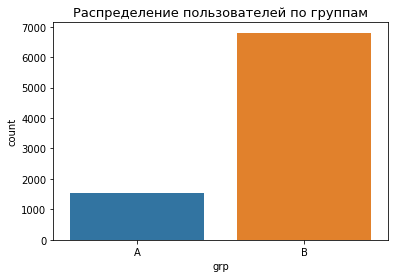

In [33]:
# посмотрим на количественное распределение пользователей по группам
plt.figure(figsize=(6, 4))
sns.countplot(x='grp', data=active_groups_all)
plt.title('Распределение пользователей по группам', fontsize=13)
sns.set_palette(['green', 'pink']) 

# Увеличение размера шрифта подписей на осях
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [34]:
active_groups_all_count = active_groups_all.groupby(['grp'], as_index=False) \
                            .agg({'id': 'count'})
active_groups_all_count.head()

,grp,id
0,A,1538
1,B,6803


In [35]:
# рассмотрим распределение внутри групп
group_a = active_groups_all.query('grp == "A"')
group_b = active_groups_all.query('grp == "B"')

In [36]:
group_a.head()

,id,grp,revenue,payment
0,1627,A,990.0,1
3,3391,A,0.0,0
13,109623,A,0.0,0
15,133678,A,0.0,0
23,175944,A,0.0,0


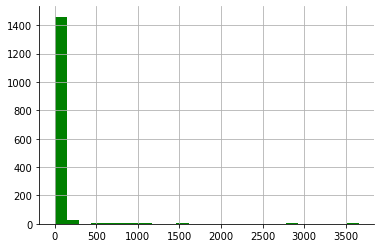

In [37]:
group_a.revenue.hist(bins=25)
sns.despine()

In [38]:
group_b.head()

,id,grp,revenue,payment
1,2085,B,0.0,0
2,2215,B,0.0,0
4,3401,B,0.0,0
5,22994,B,0.0,0
6,26899,B,0.0,0


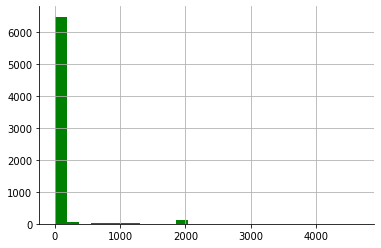

In [39]:
group_b.revenue.hist(bins=25)
sns.despine()

В обоих группах видим, что большинство пользователей оплату не совершали

In [40]:
# Cформируем датафрейм только для активных и оплативших пользователей, посмотрим его характеристики
active_groups_all_paid = active_groups_all.query('revenue > 0')

In [41]:
active_groups_all_paid.head()

,id,grp,revenue,payment
0,1627,A,990.0000,1
10,100300,B,990.0000,1
12,108270,B,290.0000,1
246,264473,B,1900.0001,1
279,274352,B,690.0000,1


In [42]:
group_a = active_groups_all_paid.query('grp == "A"')
group_b = active_groups_all_paid.query('grp == "B"')

In [43]:
group_a.head()

,id,grp,revenue,payment
0,1627,A,990.0,1
319,287008,A,1830.0,1
448,332387,A,2910.0,1
508,347455,A,2820.0,1
718,445767,A,3660.0,1


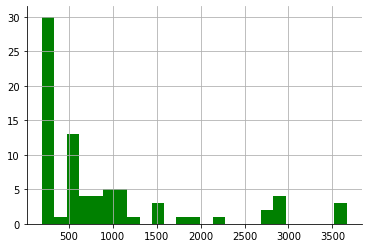

In [44]:
group_a.revenue.hist(bins=25)
sns.despine()

In [45]:
group_b.head()

,id,grp,revenue,payment
10,100300,B,990.0000,1
12,108270,B,290.0000,1
246,264473,B,1900.0001,1
279,274352,B,690.0000,1
299,280036,B,199.0000,1


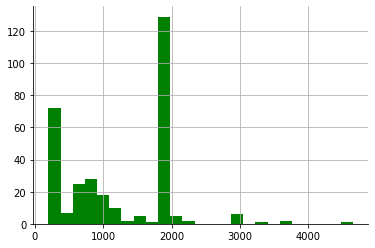

In [46]:
group_b.revenue.hist(bins=25)
sns.despine()

В данных по активным и оплатившим пользоваителям видим различия:
    в группе А наибольшее количество оплат до 1000
    в группе B есть существенное количество оплат до 1000, но преобладают оплаты около 2000, возможно именно от такой суммы чека в новой механике оплаты пользователи получали какой-то бонус в виде бесплатной доставки, подарка или промокода 

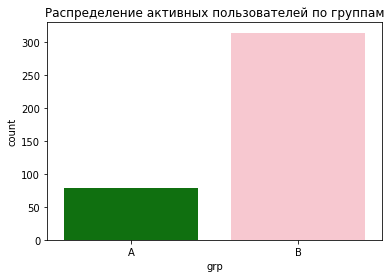

In [47]:
# посмотрим на распределение активных и плативших пользователей по группам
sns.countplot(x='grp', data=active_groups_all_paid)
plt.title('Распределение активных пользователей по группам')
plt.show()

In [48]:
# Получаем кол-во пользователей по группам (А – контроль (базовая механика), B – целевая группа (новая механика оплаты)) 
active_groups_count = active_groups_all_paid.groupby(['grp'], as_index=False) \
                            .agg({'id': 'count'})
active_groups_count.head()

,grp,id
0,A,78
1,B,314


In [49]:
 # проверим на нормальность распределения active_groups_all_count
import pingouin as pg
result = pg.normality(data=active_groups_all_paid, dv='revenue', group='grp', method='normaltest')
result

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


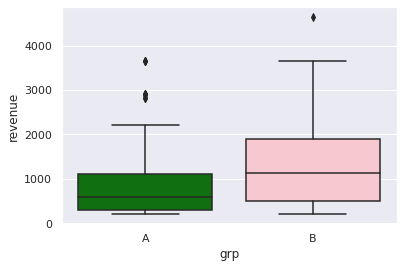

In [50]:
# Построим распределние revenue по группам
sns.set(rc={'figure.figsize' : (6,4)})
sns.set_palette(['green', 'pink'])
sns.boxplot(y='revenue', x='grp', data = active_groups_all_paid)

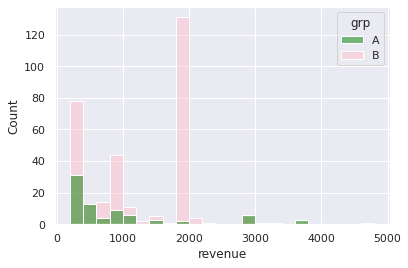

In [51]:
sns.set_palette(['green', 'pink'])
sns.histplot(data=active_groups_all_paid, x='revenue', hue="grp", binwidth = 200)

Видим, что соотношение групп А и В для активных и оплативших пользователей сохраняется
Распределение в группах A и B не соответствует нормальному, поэтому в качестве стат методов будем использовать непараметрические тесты, которые не требуют предположения о нормальности данных

Проверим гомогенность дисперсии тестом Левена
H0: выручка распределена нормально
H1: выручка распределена ненормально

In [52]:
statistic, p_value = levene(group_a['revenue'], group_b['revenue'])
print("Статистика теста Левена:", statistic)
print("p-значение:", p_value)

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: дисперсии не равны")
else:
    print("Нет оснований отвергать нулевую гипотезу: дисперсии равны")

Статистика теста Левена: 3.075681699981606
p-значение: 0.08025675761347022
Нет оснований отвергать нулевую гипотезу: дисперсии равны


## Вопросы для анализа:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

Для анализа будем использовать следующие метрики: 
    CR (конверсия в покупку)  - ключевая метрика в аналитике данных, которая (в нашем случае) показывает процент пользователей, совершивших покупку от общего числа пользователей или посетителей
    средний чек - метрика в аналитике данных, которая показывает среднюю сумму денег, которую каждый клиент тратит за одну покупку или заказ
    ARPU - метрика, которая используется для оценки эффективности монетизации пользователей и понимания того, сколько денег в среднем приносит каждый пользователь

### Конверсия 

In [53]:
grouped_data = active_groups_all.groupby('grp')
conversion_rate = grouped_data['revenue'].apply(lambda x: (x > 0).mean() * 100)
print(conversion_rate.head())

grp
A    5.071521
B    4.615611
Name: revenue, dtype: float64


In [54]:
cr_group_A = conversion_rate[conversion_rate.index == 'A'].values[0]
cr_group_B = conversion_rate[conversion_rate.index == 'B'].values[0]

percent_change_cr = ((cr_group_B - cr_group_A) / cr_group_A) * 100
print(f'Изменение Conversion Rate между группами A и B в процентах: {percent_change_cr}%')


Изменение Conversion Rate между группами A и B в процентах: -8.989623733119238%


Подсчеты показали, что введение нового механизма оплаты снизило конверсию на 8.99% в группе В относительно группы А. Положительного эффекта достичь не удалось, и на это может быть ряд причин: новый механизм оплаты может быть неудобен для пользователей, либо пользователи могли быть недостаточно информированы о новом механизме оплаты или его преимуществах, возможно, новый механизм оплаты мог вызвать технические проблемы или сбои в работе сервиса.

Т.к. мы хотим проверить статистическую значимость связи между категориальными переменными, воспользуемся критерием Хи-квадрат

Сформулируем нулевую и альтернативную гипотезу:
H0 - конверсия в покупку не зависит от механизма платежа, уровень значимости -  0.05
H1 - конверсия в покупку зависит от механизма платежа

In [55]:
from scipy.stats import chi2_contingency

# Создание таблицы сопряженности для теста хи-квадрат
contingency_table = pd.crosstab(active_groups_all['grp'], active_groups_all['payment'])
contingency_table

payment,0,1
grp,,
A,1460,78
B,6489,314


In [56]:
# Выполнение теста хи-квадрат
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05

print("Хи-квадрат статистика:", chi2)
print("P-значение:", p_val)

if p_val < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая связь между механизмом платежа и конверсией в покупку.")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимой связи между механизмом платежа и конверсией в покупку.")

Хи-квадрат статистика: 0.48480826522557896
P-значение: 0.48625240457231045
Не отвергаем нулевую гипотезу: нет статистически значимой связи между механизмом платежа и конверсией в покупку.


### Средний чек

In [57]:
avg_check = active_groups_all_paid[active_groups_all_paid['revenue'] > 0].groupby('grp')['revenue'].mean()
avg_check.head()

grp
A     933.589744
B    1257.878992
Name: revenue, dtype: float64

In [58]:
avg_check_A = avg_check['A']
avg_check_B = avg_check['B']

percent_change_avg_check = ((avg_check_B - avg_check_A) / avg_check_A) * 100
print(f'Изменение среднего чека между группами A и B в процентах: {percent_change_avg_check}%')

Изменение среднего чека между группами A и B в процентах: 34.73573383545856%


Средний чек в экспериментальной группе В выше, чем в контрольной А на 34.74%, это говорит о том, что при внедрении новой механики оплаты пользователи стали тратить больше. 

Сформулируем нулевую и альтернативную гипотезу:
H0 - средние чеки в двух группах не отличаются
H1 - средние чеки в двух группах отличаются

Для проверки выдвинутых гипотез воспользуемся методом бутстрап

In [59]:
# функция для bootstrap

def get_bootstrap(data, group_column, value_column, stat_func, boot_it=1000, bootstrap_conf_level=0.95, graph=True):
    groups = data[group_column].unique()
    boot_data = []
    
    for i in tqdm(range(boot_it), disable=not graph):
        samples = []
        for group in groups:
            group_sample = data[data[group_column] == group][value_column].sample(frac=1, replace=True)
            samples.append(stat_func(group_sample))
        boot_data.append(samples[1] - samples[0])
        
    pd_boot_data = pd.DataFrame(boot_data, columns=['difference'])
    
    # считаем доверительный интервал
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - left_quant
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    # P-value
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    # График
    if graph:
        plt.hist(pd_boot_data['difference'], bins=50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=max(plt.hist(pd_boot_data['difference'], bins=50)[0]), colors='red', linestyle='--')
        plt.xlabel('Difference in ' + value_column)
        plt.ylabel('Frequency')
        plt.title("Bootstrap Distribution of Difference in " + value_column)
        plt.show()
    
    return {"ci": ci, "p_value": p_value}

def aov_func(x):
    """Средний чек"""
    return np.mean(x[x > 0])

100%|██████████| 1000/1000 [00:02<00:00, 406.17it/s]


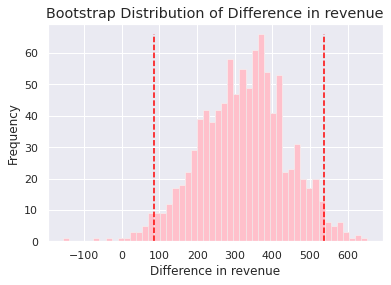

Доверительные интервалы для среднего чека:
       difference
0.025   86.025124
0.975  536.843618
P-value для среднего чека: 0.005179647252337219


In [60]:
result_aov = get_bootstrap(data=active_groups_all_paid, group_column='grp', value_column='revenue', stat_func=aov_func)
print("Доверительные интервалы для среднего чека:")
print(result_aov["ci"])
print("P-value для среднего чека:", result_aov["p_value"])



Вывод: отвергаем H0, различие в чеках двух групп статистически значимы, новая механика повышает средний чек

### ARPU

In [61]:
paid_A = active_groups_all_paid.query('grp == "A"')
paid_B = active_groups_all_paid.query('grp == "B"')

In [62]:
ARPU_A = paid_A['revenue'].sum() / active_groups_all.query('grp == "A"')['id'].count()
ARPU_B = paid_B['revenue'].sum() / active_groups_all.query('grp == "B"')['id'].count()

print(ARPU_A)
print(ARPU_B)

47.34720416124838
58.05879810377775


In [63]:
# посмотрим на процентное соотношение
percent_change_ARPU = (ARPU_B - ARPU_A) / ARPU_A * 100
print(f'Процентное изменение: {percent_change_ARPU}%')

Процентное изменение: 22.62349832959375%


Средняя выручка, которую приносит один пользователь в экспериментальной группе больше В, чем в тестовой А, такое увеличение может быть результатом более высокого среднего чека, что показывает эффективность внедрения нового механизма оплаты.

Сформулируем нулевую и альтернативную гипотезу:
H0 - ARPU в двух группах не отличается
H1 - ARPU в двух группах отличается

Для проверки выдвинутых гипотез применим т-тест Уэлча

In [64]:
# Выполняем т-тест Уэлча
t_stat, p_value = stats.ttest_ind(paid_A['revenue'], paid_B['revenue'], equal_var=False)

print(f"Значение t-статистики: {t_stat}")
print(f"p-значение: {p_value}")

Значение t-статистики: -2.861689755269415
p-значение: 0.005069734012800116


Можно сделать вывод о статистической значимости различий между ARPU групп A и B, мы можем отвергнуть нулевую гипотезу о равенстве ARPU в группах A и B

## Вывод

Для проведения анализа эффективности внедрения нового механизма оплаты были рассмотрены три метрики:
CR в покупку - наблюдалось снижение конверсии на 8.99%, но при этом применение стат тестов показало, что нет статистически значимой связи между механизмом платежа и конверсией в покупку.
Средний чек - вырос 34.74%, по результатам проведения стат тестов, выявленное различие в среднем чеке между группами является статистически значимым.
ARPU - средняя выручка выросла на 22.62%, есть стат значимое различие между группами.

Исходя из проанализированных данных, можно рекомендовать внедрение нового механизма оплаты 

# Задание 2

### Необходимо реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.


In [65]:
def metrics_upd (groups, groups_add, active_studs, checks):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
    final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
    response_groups_add = requests.get(final_url_groups_add)
    download_url_groups_add = response_groups_add.json()['href']
    groups_add = pd.read_csv(download_url_groups_add) 
    
    #В задании отмечено, что заголовки таблицы могут отличаться. Переименуем их  
    groups_add.rename(columns=({groups_add.columns[0]: 'id', groups_add.columns[1]: 'grp'}), inplace=True)   
   
    # Объединяем датафреймы
    groups_merged = pd.concat([groups, groups_add], ignore_index=True)
    active_checks = active_studs.merge(checks, on='student_id', how = 'left')
    
    # Переименовываем столбцы в полученном датафрейме
    active_checks = active_checks.rename(columns = {'student_id': 'id', 'rev': 'revenue'})
    # Для дальнейшего удобства заменим NaN на 0
    active_checks['revenue'] = active_checks.revenue.fillna(0)
    
    # Объединяем groups_merged и active_checks
    active_groups_all = groups_merged.merge(active_checks, on='id')
    
    # добавим колонку payment, чтобы видеть метку об оплате
    active_groups_all['payment'] = active_groups_all.revenue.apply(lambda x: 0 if x == 0 else 1)

    # Cформируем датафрейм только для активных и оплативших пользователей
    active_groups_all_paid = active_groups_all.query('revenue > 0')
    
    # Рассчитываем CR (Conversion Rate) для каждой группы 
    grouped_data = active_groups_all.groupby('grp')
    conversion_rate = grouped_data['revenue'].apply(lambda x: (x > 0).mean() * 100)
    cr_group_A = conversion_rate[conversion_rate.index == 'A'].values[0]
    cr_group_B = conversion_rate[conversion_rate.index == 'B'].values[0]
    
    # Рассчитываем средний чек для каждой группы 
    avg_check = active_groups_all_paid[active_groups_all_paid['revenue'] > 0].groupby('grp')['revenue'].mean()
    avg_check_A = avg_check['A']
    avg_check_B = avg_check['B']
    
    # Рассчитываем ARPU (Average Revenue Per User) для каждой группы
    paid_A = active_groups_all_paid.query('grp == "A"')
    paid_B = active_groups_all_paid.query('grp == "B"')
    ARPU_A = paid_A['revenue'].sum() / active_groups_all.query('grp == "A"')['id'].count()
    ARPU_B = paid_B['revenue'].sum() / active_groups_all.query('grp == "B"')['id'].count()
    
    print('Конверсия в покупку для контрольной (А) группы:', cr_group_A)
    print('Конверсия в покупку для тестовой (В) группы:',  cr_group_B)
    print('Средний чек для контрольной(А) группы:', avg_check_A)
    print('Средний чек для тестовой(B) группы:', avg_check_B)
    print('ARPU для контрольной(А) группы:', ARPU_A)
    print('ARPU для тестовой(В) группы:', ARPU_B)
    
    df_metrics = pd.DataFrame({
        'group': ['A', 'B'],
        'CR': [cr_group_A, cr_group_B],
        'avg_check': [avg_check_A, avg_check_B],
        'ARPU': [ARPU_A, ARPU_B]
    })
    
    return df_metrics

result_metrics_upd = metrics_upd(groups, groups_add, active_studs, checks)

Конверсия в покупку для контрольной (А) группы: 5.071521456436931
Конверсия в покупку для тестовой (В) группы: 4.615610759958842
Средний чек для контрольной(А) группы: 933.5897435897435
Средний чек для тестовой(B) группы: 1257.878992038217
ARPU для контрольной(А) группы: 47.34720416124838
ARPU для тестовой(В) группы: 58.05879810377775


In [66]:
result_metrics_upd

,group,CR,avg_check,ARPU
0,A,5.071521,933.589744,47.347204
1,B,4.615611,1257.878992,58.058798


### Реализуйте функцию, которая будет строить графики по получаемым метрикам

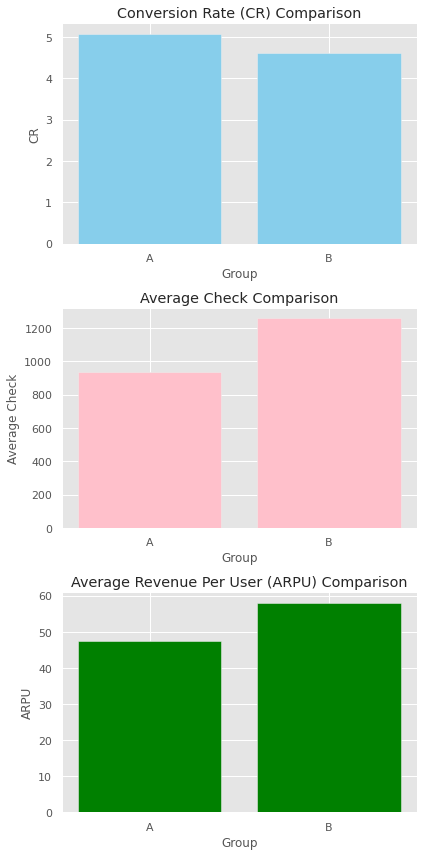

In [67]:
def visualize_metrics(result_metrics_upd):
    plt.figure(figsize=(6, 12))

    # График для метрики CR
    plt.subplot(3, 1, 1)
    plt.bar(result_metrics_upd['group'], result_metrics_upd['CR'], color='skyblue')
    plt.xlabel('Group')
    plt.ylabel('CR')
    plt.title('Conversion Rate (CR) Comparison')

    # График для метрики avg_check
    plt.subplot(3, 1, 2)
    plt.bar(result_metrics_upd['group'], result_metrics_upd['avg_check'], color='pink')
    plt.xlabel('Group')
    plt.ylabel('Average Check')
    plt.title('Average Check Comparison')

    # График для метрики ARPU
    plt.subplot(3, 1, 3)
    plt.bar(result_metrics_upd['group'], result_metrics_upd['ARPU'], color='green')
    plt.xlabel('Group')
    plt.ylabel('ARPU')
    plt.title('Average Revenue Per User (ARPU) Comparison')

    plt.tight_layout()
    plt.show()

# Вызов функции для визуализации метрик из DataFrame result_metrics_upd
visualize_metrics(result_metrics_upd)

